# Toxic Comment Classification

## Introduction

This is a school project which we apply our knowledge on Recurrent Neural Networks (RNN) to build a model that is capable of detecting toxic comments.

Nowadays, since more people start to get involved in social networks and share their personal opinion regarding different topics online, the threat of online abuse and harassment appear frequently which prevents effective conversations. Toxic comments are one of the negative online behaviors. 

According to the description of "Toxic Comment Classification Challenge" on Kaggle: 
"The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content)."

We are intrigued by this topic and decide to build a model which is capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate utilizing RNN. The dataset we used are the comments from Wikipedia’s talk page edits.

We gathered our datasets and ideas about this project from Toxic Comment Classification Challenge on Kaggle . Since this is a finished challenge, there are already some existing models. Some of the models used the NBSVM (Naive Bayes - Support Vector Machine) approach, and others also tried the logistic regression model. Since this is a topic related to natural language processing and knowing RNN would be a good model to deal with sequential data, our group decided to approach this problem using RNN. The initial idea of our model is based on one of the kernel posts on Kaggle in which the competitor used LSTM layers to tackle this problem. We found this resource inspirational, and we built our model based on it with additional modifications such as adding batch normalization layers and using weight regularization on dense layers. Further explanations will be given along with our model.



## Import Packages

**matplotlib**, **seaborn**, and **worldcloud** packages are used to do data visualization.

**nltk** package is used to do some data preprocessing on the comments.

**keras** package is used to build our RNN model.

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading Toxic Comment Datasets:

In [0]:
train = pd.read_csv('/content/gdrive/My Drive/DATA 2040 Final Project/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/DATA 2040 Final Project/test.csv')
test_label = pd.read_csv('/content/gdrive/My Drive/DATA 2040 Final Project/test_labels.csv')

In [5]:
print('shape of training set: ', train.shape)
train.head()

shape of training set:  (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test_label = test_label[test_label.toxic != -1]
test = pd.merge(test, test_label, how='inner', on='id')
print('shape of test set: ', test.shape)
test.head()

shape of test set:  (63978, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


## Explanatory Data Analysis

* Check missing values in the data set:

In [7]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [8]:
test.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

- Check the distribution of toxic vs non-toxic comments

In [9]:
train['non_toxic'] = train.iloc[:,2:].apply(lambda row: 1 if sum(row)==0 else 0,
                                            axis = 1)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


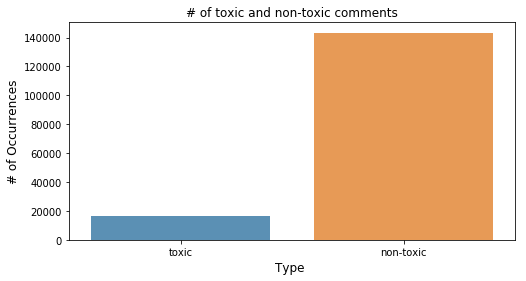

In [10]:
xs = ['toxic', 'non-toxic']
vals = [len(train)-train['non_toxic'].sum(), train['non_toxic'].sum()]
plt.figure(figsize=(8,4))
ax = sns.barplot(xs, vals, alpha=0.8)
plt.title('# of toxic and non-toxic comments')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
plt.show()

According to the bar chart, it can be observed that most of the comments are non-toxic, and this is a problem with imbalanced results.

- Check distribution of toxic comments accross classes

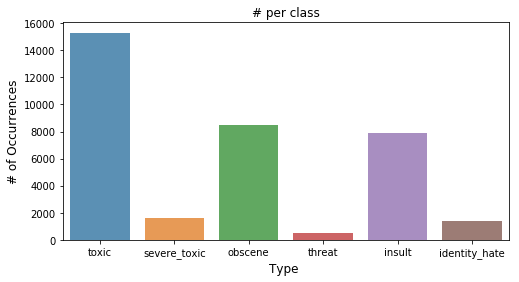

In [11]:
num_comments = train.iloc[:, 2:-1].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(num_comments.index, num_comments.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
plt.show()

From the above bar plot, we observed that for the toxic comments, the number of occurrences is different across various types of toxicity. We think this may be because of the severity of toxicity. In addition, by simply scanning through the dataset, we found that some of the comments were labeled with more than one type of toxicity. With the above two observations, we decided to further observing the pattern of co-occurance using correlation heatmap.

- Pattern of co-occurance of different types of toxic comments

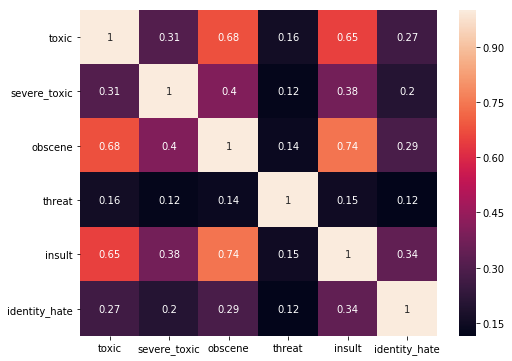

In [12]:
corr=train.iloc[:, 2:-1].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

The correlation matrix indicates certain level of co-occurance between different types of toxic comments. As shown above, toxic vs obscene and toxic vs insult have high correlations.

### Word Cloud

For now, we have observed the distribution of different types of toxic comments in our train data set. As next step, we worked on finding the frequency of words in different types of comments using word cloud.

In [0]:
stopword=set(STOPWORDS)

In [0]:
mask = np.array(Image.open('/content/gdrive/My Drive/DATA 2040 Final Project/mask-cloud.png'))

mask = mask[:, :, 1]

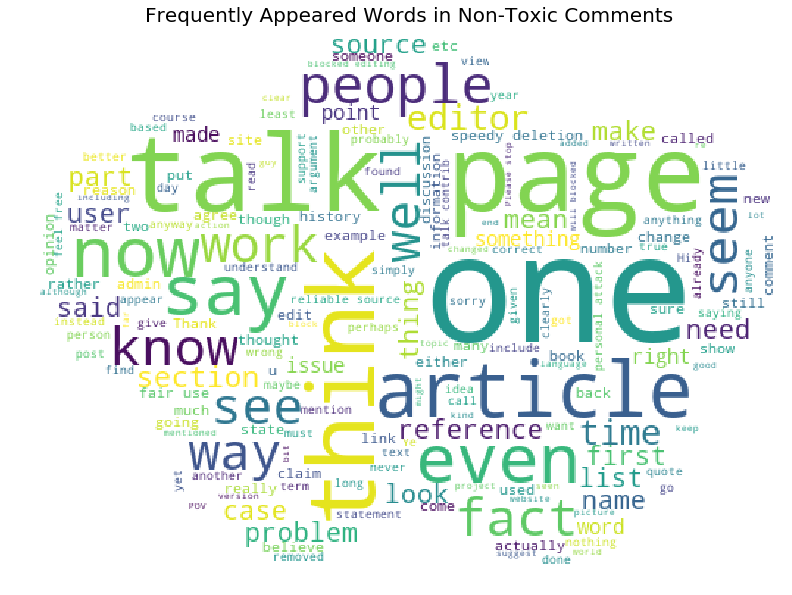

In [15]:
subset=train[train['non_toxic']==1]
text=subset['comment_text'].values
wc= WordCloud(background_color="white",max_words=2000,mask=mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Frequently Appeared Words in Non-Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis', random_state=17), alpha=0.98)
plt.show()

The most frequent appeared words in non-toxic comments are mostly verbs and several nouns.

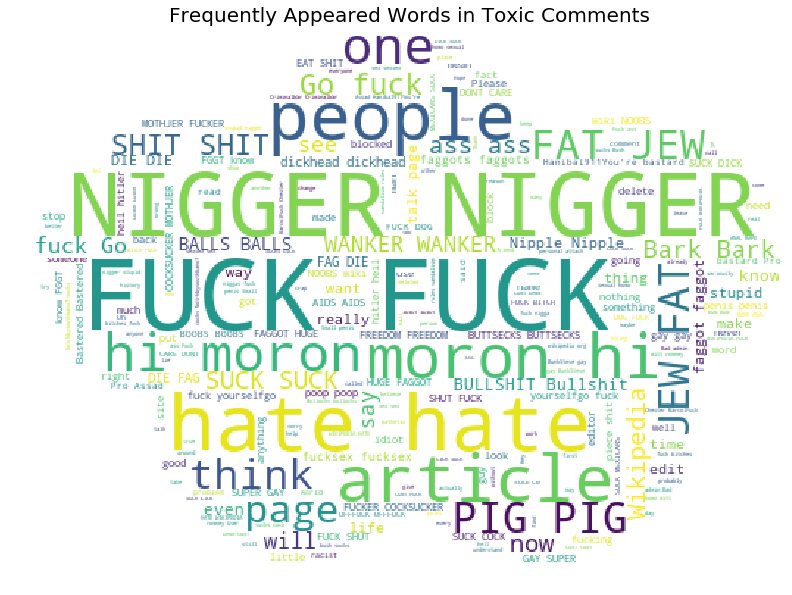

In [16]:
subset=train[train['toxic']==1]
text=subset['comment_text'].values
wc= WordCloud(background_color="white",max_words=2000,mask=mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Frequently Appeared Words in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis', random_state=17), alpha=0.98)
plt.show()

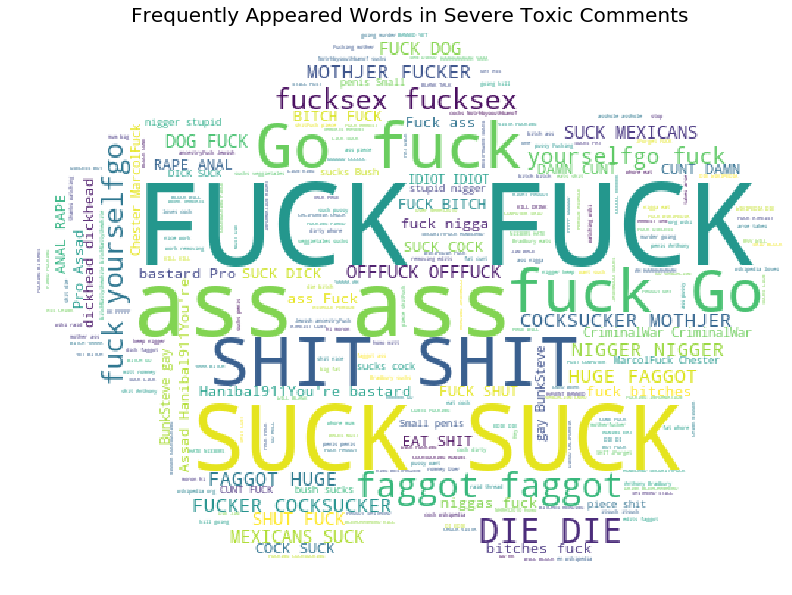

In [17]:
subset=train[train['severe_toxic']==1]
text=subset['comment_text'].values
wc= WordCloud(background_color="white",max_words=2000,mask=mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Frequently Appeared Words in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis', random_state=17), alpha=0.98)
plt.show()

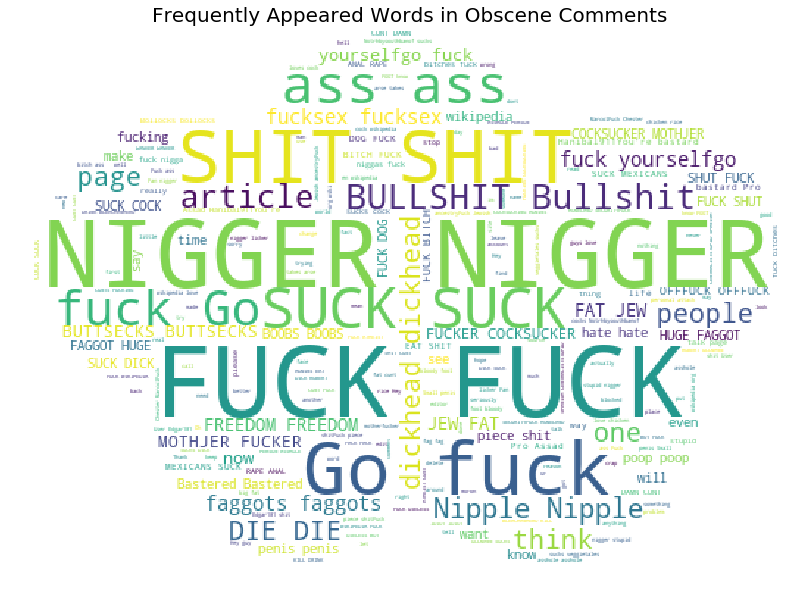

In [19]:
subset=train[train['obscene']==1]
text=subset['comment_text'].values
wc= WordCloud(background_color="white",max_words=2000,mask=mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Frequently Appeared Words in Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis', random_state=17), alpha=0.98)
plt.show()

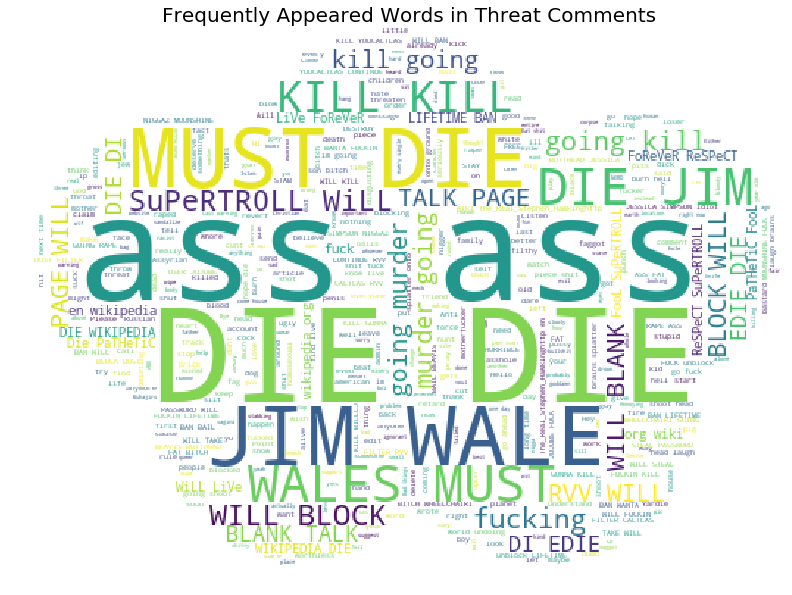

In [18]:
subset=train[train['threat']==1]
text=subset['comment_text'].values
wc= WordCloud(background_color="white",max_words=2000,mask=mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Frequently Appeared Words in Threat Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis', random_state=17), alpha=0.98)
plt.show()

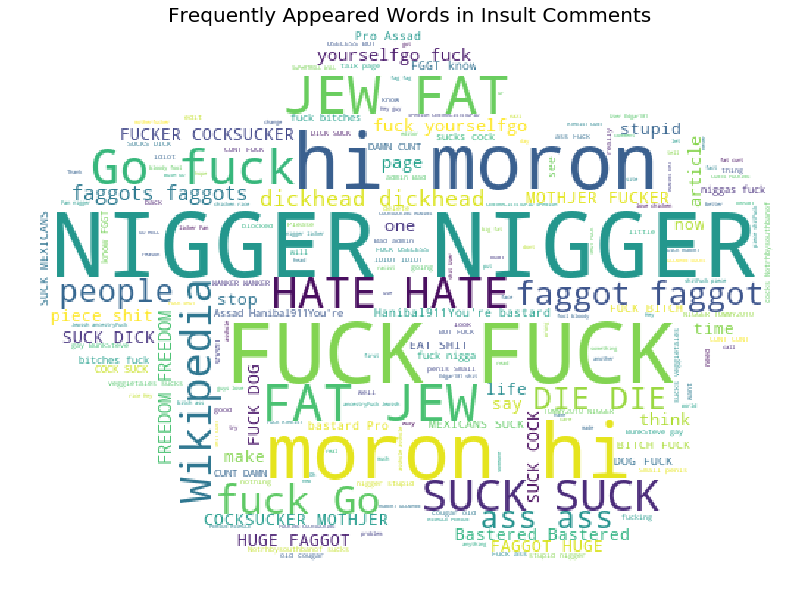

In [20]:
subset=train[train['insult']==1]
text=subset['comment_text'].values
wc= WordCloud(background_color="white",max_words=2000,mask=mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Frequently Appeared Words in Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis', random_state=17), alpha=0.98)
plt.show()

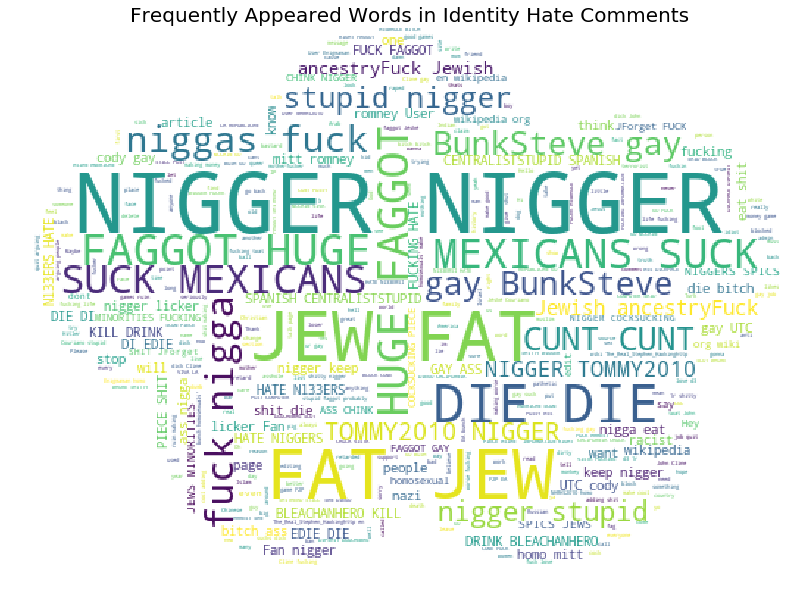

In [21]:
subset=train[train['identity_hate']==1]
text=subset['comment_text'].values
wc= WordCloud(background_color="white",max_words=2000,mask=mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Frequently Appeared Words in Identity Hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis', random_state=17), alpha=0.98)
plt.show()

As for the most frequent appeared words in toxic comments, we can see a lot of discriminated words and profanities.

## Data Preprocessing

Preparing y values:

In [0]:
toxic_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 
                 'identity_hate']
y_train = train[toxic_classes]
y_test = test[toxic_classes]

In [23]:
y_train.sample(5)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
58463,0,0,0,0,0,0
49779,0,0,0,0,0,0
9659,0,0,0,0,0,0
138304,0,0,0,0,0,0
139928,0,0,0,0,0,0


In [24]:
y_test.sample(5)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
40916,0,0,0,0,0,0
44896,0,0,0,0,0,0
2098,0,0,0,0,0,0
44364,0,0,0,0,0,0
11873,0,0,0,0,0,0


Preparing x values:

In [0]:
x_train = train['comment_text']
x_test = test['comment_text']

x_train = x_train.apply(lambda x: x.lower())
x_test = x_test.apply(lambda x: x.lower())

In [26]:
x_train.sample(5)

134811    harry champion - latest editions \n\nhi there,...
157444    merge 2015 \n\ncan we just redirect it to vamp...
156567    file:losaltoscalm.gif listed for deletion \nan...
106296    green movement\n\npls put this userbox in your...
67054     "\n\nregarding melanie slade: please stop. if ...
Name: comment_text, dtype: object

In [27]:
x_test.sample(5)

48204    "(outsy) ooo, no cheating. big turn-off... (jk...
27629    list of films featuring time loops  \n please ...
47212    the length of the article is both our faults, ...
12224    == advance wars indepth walkthroughs == \n\n n...
27615    == wrong picture. == \n yes, i agree, the imag...
Name: comment_text, dtype: object

create validation data:

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.30, random_state=42)

In [29]:
x_val.head()

119105    geez, are you forgetful!  we've already discus...
131631    carioca rfa \n\nthanks for your support on my ...
125326    "\n\n birthday \n\nno worries, it's what i do ...
111256    pseudoscience category? \n\ni'm assuming that ...
83590     (and if such phrase exists, it would be provid...
Name: comment_text, dtype: object

In [30]:
y_val.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
119105,0,0,0,0,0,0
131631,0,0,0,0,0,0
125326,0,0,0,0,0,0
111256,0,0,0,0,0,0
83590,0,0,0,0,0,0


Since we cannot feed words or sentences directly into the neural network, we need to preprocessing our input for x using following steps:

1. Tokenization - We need to break down the each comment into words.

2. Indexing - We assign an index to each unique word in our dataset.

3. Index Representation- We represent our comment using the index we assign to each word.

Removing stop words:

In [31]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
stop_words = stopwords.words('english')
list_x_train = list(x_train)
x_tokens = [word_tokenize(x.lower()) for x in list_x_train]
filtered_sentences = []
for sentence in x_tokens:
    temp = [w for w in sentence if not w in stop_words]
    filtered_sentences.append(" ".join(temp))

In [0]:
#the maximum number of words to keep, based on word frequency
num_words = 20000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(filtered_sentences)
x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_val_tokenized = tokenizer.texts_to_sequences(x_val)
x_test_tokenized = tokenizer.texts_to_sequences(x_test)

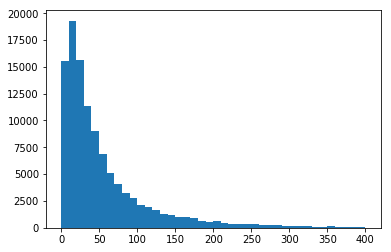

In [34]:
totalNumWords = [len(x) for x in x_train_tokenized]
plt.hist(totalNumWords, bins=np.arange(0,410,10))
plt.show()

We used the padding methods to regularize the length of each input comment vector. The input vectors should have the same length to be able to put into the Neural Network. Since each comments have different length, we need to padding 0 values to shorter sentences. It can be observed from the histogram that almost all the sentences have lengths less than 300; therefore, we decided to use a vector length of 300 to represent each comment.

In [0]:
maxlen = 300
x_train_padding = pad_sequences(x_train_tokenized, maxlen=maxlen, padding = "post", truncating = "post")
x_val_padding = pad_sequences(x_val_tokenized, maxlen=maxlen, padding = "post", truncating = "post")
x_test_padding = pad_sequences(x_test_tokenized, maxlen=maxlen, padding = "post", truncating = "post")

In [36]:
x_train_padding[0]

array([  636,   978,   385,    99,  2267,  5436,    24,    37,  1244,
         438,  2824,   943,  2131,   577,   524,  1193,   881,     9,
          69,   636,   978,   385,   289,  4498,    31,  4498,  3980,
        1866,  7440,  5099,   100,  5436,   216,  3100,  4662,     9,
        1367,  6258,   410,  4505,  5436, 14342,  2163,   708,  6103,
          25,   708,   362,    46,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [37]:
x_test_padding[0]

array([   53,   943,  1866,   998,   302,    14, 15912,   985,   978,
         943,   708,     8,  2392,   248,    88,    60,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

##Model Building:



### Structure of Initial model

In [57]:
model_1 = models.Sequential()
model_1.add(layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen))
model_1.add(layers.CuDNNLSTM(60, return_sequences=True))
model_1.add(layers.GlobalMaxPool1D())
model_1.add(layers.Dropout(0.1))
model_1.add(layers.Dense(50, activation='relu'))
model_1.add(layers.Dropout(0.1))
model_1.add(layers.Dense(6, activation='sigmoid'))
model_1.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 128)          2560000   
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 300, 60)           45600     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 60)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 306       
Total para

In [62]:
history_1 = model_1.fit(x_train_padding,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val_padding, y_val))

Train on 111699 samples, validate on 47872 samples
Epoch 1/10
111699/111699 [==============================] - 20s 176us/sample - loss: 0.0249 - acc: 0.9903 - val_loss: 0.0662 - val_acc: 0.9806
Epoch 2/10
111699/111699 [==============================] - 19s 166us/sample - loss: 0.0227 - acc: 0.9910 - val_loss: 0.0729 - val_acc: 0.9798
Epoch 3/10
111699/111699 [==============================] - 19s 167us/sample - loss: 0.0206 - acc: 0.9919 - val_loss: 0.0855 - val_acc: 0.9803
Epoch 4/10
111699/111699 [==============================] - 19s 168us/sample - loss: 0.0189 - acc: 0.9927 - val_loss: 0.0823 - val_acc: 0.9798
Epoch 5/10
111699/111699 [==============================] - 20s 177us/sample - loss: 0.0167 - acc: 0.9934 - val_loss: 0.0949 - val_acc: 0.9798
Epoch 6/10
111699/111699 [==============================] - 20s 180us/sample - loss: 0.0150 - acc: 0.9942 - val_loss: 0.0934 - val_acc: 0.9782
Epoch 7/10
111699/111699 [==============================] - 19s 172us/sample - loss: 0.0140

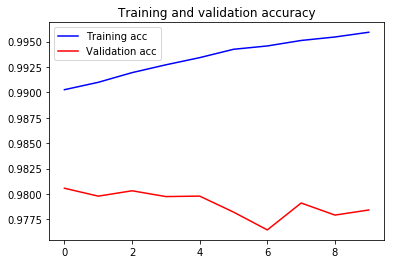

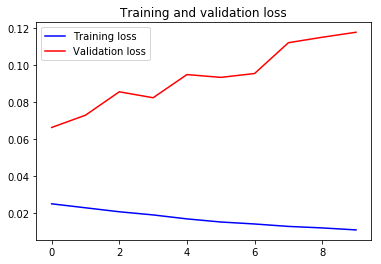

In [63]:
acc = history_1.history['acc']
val_acc = history_1.history['val_acc']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [64]:
model_1.evaluate(x_test_padding, y_test)

63978/63978 [==============================] - 14s 219us/sample - loss: 0.1621 - acc: 0.9643


[0.162108244848284, 0.9643208]

We trained this model based on the preprocessed training dataset and evaluation our model using validation data during the training process. By testing our model using test data, we got a loss of 0.16 and an accuracy score of 0.96. Further, we plotted the training vs validation accuracy and loss using line chart in order to observed the trend. 

From the line charts, we observed that the initial model may have a overfitting problem with continuing increased training accuracy and continuing decreased validation accuracy. Therefore, we decided to do some modifications on the initial model to mitigate the overfitting problem and achieve faster training. The strategies we used are batch normalization, L2 regularization, and early stopping.

### Structure of our model

In [65]:
model_2 = models.Sequential()
model_2.add(layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen))
model_2.add(layers.CuDNNLSTM(60, return_sequences=True))
model_2.add(layers.GlobalMaxPool1D())
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(50, kernel_regularizer=regularizers.l2(0.001),activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.1))

model_2.add(layers.Dense(6, activation='sigmoid'))
model_2.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 128)          2560000   
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 300, 60)           45600     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 60)                0         
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 60)                240       
_________________________________________________________________
dropout_11 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                3050      
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 50)                200       
__________

In [68]:
callbacks = [keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                           patience = 3, 
                                           mode = 'max')]
history_2 = model_2.fit(x_train_padding, 
                        y_train, 
                        epochs=10, 
                        batch_size=128, 
                        validation_data=(x_val_padding, y_val), 
                        callbacks=callbacks)

Train on 111699 samples, validate on 47872 samples
Epoch 1/10
111699/111699 [==============================] - 21s 187us/sample - loss: 0.1898 - acc: 0.9438 - val_loss: 0.0653 - val_acc: 0.9801
Epoch 2/10
111699/111699 [==============================] - 22s 194us/sample - loss: 0.0572 - acc: 0.9817 - val_loss: 0.0521 - val_acc: 0.9826
Epoch 3/10
111699/111699 [==============================] - 21s 187us/sample - loss: 0.0467 - acc: 0.9839 - val_loss: 0.0502 - val_acc: 0.9830
Epoch 4/10
111699/111699 [==============================] - 20s 180us/sample - loss: 0.0405 - acc: 0.9853 - val_loss: 0.0539 - val_acc: 0.9806


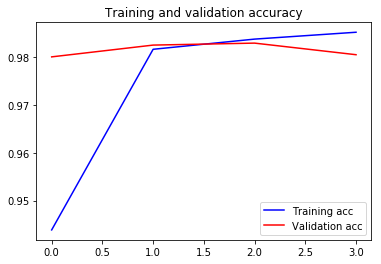

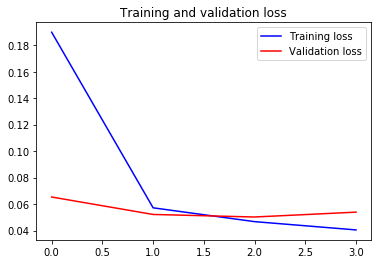

In [69]:
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [70]:
model_2.evaluate(x_test_padding, y_test)

63978/63978 [==============================] - 16s 243us/sample - loss: 0.0934 - acc: 0.9637


[0.09336242849271777, 0.9637374]

During our training, we added a callback to enable early stopping of our model when the loss stops decreasing for 3 epochs. We trained our new model based on the preprocessed training dataset and evaluation our model using validation data during the training process. The training process stops at the 4th epoch this time. By testing our model using out-sample test data, we got a loss of 0.09 and an accuracy score of 0.96. Further, we plotted the training vs validation accuracy and loss using line chart in order to observed the trend.

From the line charts, it can be observed that we mitigated the overfitting problem while still preserving the same accuracy on the out-sample testing set. Our training process stopped when the model started to overfit, and in this way, we achieved faster training.  

Conclusion

In this project, recurrent neural network and LSTM cells were used to tackle the toxic comment  classification problem. As overfitting being the problem in the initial model we found online, we handled this problem by adding L2 regularizer in the dense layer and adding early stopping callback during our training process. In addition, in order to avoid vanishing gradient problem and achieving faster training, we also implemented batch normalization layers. As a result, we successfully mitigate the overfitting problem and get a final loss of 0.09 and final accuracy score of 0.96 on our out-sample test set.

Reference:

Toxic Comment Classification Competition on Kaggle:

Description:

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

Data: 

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Kernels:

https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras

DATA 2040 Lecture Notes, by Professor Samuel Watson:

https://drive.google.com/file/d/1Gk8YERUwmqxsCQqPsPjr_Ua99imq-ist/view